# Lab 2: Simple classification models

In the previous session we introduced some basic machine learning concepts and applied them to a simple **regression** problem. In a regression task, we try to predict the exact value of a target. Many machine learning tasks however require assigning a discrete label to each input data point. This is known as **classification**. Some typical classification tasks are **image recognition**, classifying credit card transactions as legitimate or not, detecting spam, predicting whether the stock price will go up or down (while predicting the exact value is regression).

In this session we will apply two very simple classification models to the task of heart disease prediction i.e. predicting whether a patient is at risk of heart disease based on measurements like age, gender, cholesterol level, ...

We will explore two different simple classification models: **K-nearest neighbors** and **logistic regression**. These two are typical examples for two families of machine learning models:
- **Parametric models** have a fixed number of parameters that are used to learn. Examples of parametric models are linear regression, logistic regression, SVMs, neural networks, ...
- **Non-parametric models** have no fixed number of parameters, instead the number of parameters grows with the amount of training data. A typical example is K-nearest neighbors.



<img src="images/boundary.png" width="600" style="float:left" /> <br/>

To classify data, we model **decision boundaries**, boundaries in high dimensional space that separate the different classes the best as possible. Usually, these boundaries are not perfect so we will again need some **performance metrics** to quantify how good our classification is.

In case we are distinguishing between two classes (e.g. spam or not) we are performing **binary classification**, if we are distinguishing between multiple classes, it is called **multi-class classification**. In the binary classification case we often use the terms **postive and negative examples** to indicate whether they belong to the class or not.

## The data
This dataset contains a set of medical observations of different persons, each with a label indicating whether the patient has a heart disease or not. Our task is to predict whether a new patient is at risk of hear disease.

<img src="images/image.jpg" width="600" style="float:left"/>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

dataset = pd.read_csv("data/heart.csv",header=0, delim_whitespace=False)
dataset.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [2]:
dataset.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.366337,0.683168,0.966997,131.623762,246.264026,0.148515,0.528053,149.646865,0.326733,1.039604,1.399340,0.729373,2.313531,0.544554
std,9.082101,0.466011,1.032052,17.538143,51.830751,0.356198,0.525860,22.905161,0.469794,1.161075,0.616226,1.022606,0.612277,0.498835
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,47.500000,0.000000,0.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,55.000000,1.000000,1.000000,130.000000,240.000000,0.000000,1.000000,153.000000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000
75%,61.000000,1.000000,2.000000,140.000000,274.500000,0.000000,1.000000,166.000000,1.000000,1.600000,2.000000,1.000000,3.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000


These columns represent:
- age - age in years
- sex - (1 = male; 0 = female)
- cp - chest pain type
- trestbps - resting blood pressure (in mm Hg on admission to the hospital)
- chol - serum cholestoral in mg/dl
- fbs - (fasting blood sugar > 120 mg/dl) (1 = true; 0 = false)
- restecg - resting electrocardiographic results
- thalach - maximum heart rate achieved
- exang - exercise induced angina (1 = yes; 0 = no)
- oldpeak - ST depression induced by exercise relative to rest
- slope - the slope of the peak exercise ST segment
- ca - number of major vessels (0-3) colored by flourosopy
- thal - 3 = normal; 6 = fixed defect; 7 = reversable defect
- target - have disease or not (1=yes, 0=no)

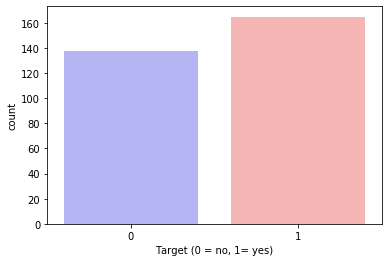

In [3]:
sns.countplot(dataset.target, palette="bwr")
plt.xlabel("Target (0 = no, 1= yes)")
plt.show()

The above plot shows that we have approximately the same number of positive and negative examples. This is called a **balanced** dataset. Balanced data makes our life easier. Care has to be taken in case of **imbalanced** data as the model can easily collapse to the trivial solution of always returning the same prediction. In case of 90% positive examples, it is trivial for the model to obtain a 90% accuracy without having learned anything useful. If your data is imbalanced, it might be necessary to balance it manually by either subsampling the largest class or by oversampling the smaller class. It might also be possible to generate **synthetic data** or to do **dataset augmentation**. Another solution could be to change your model or **cost function** to put more weight on samples from the underrepresented class.

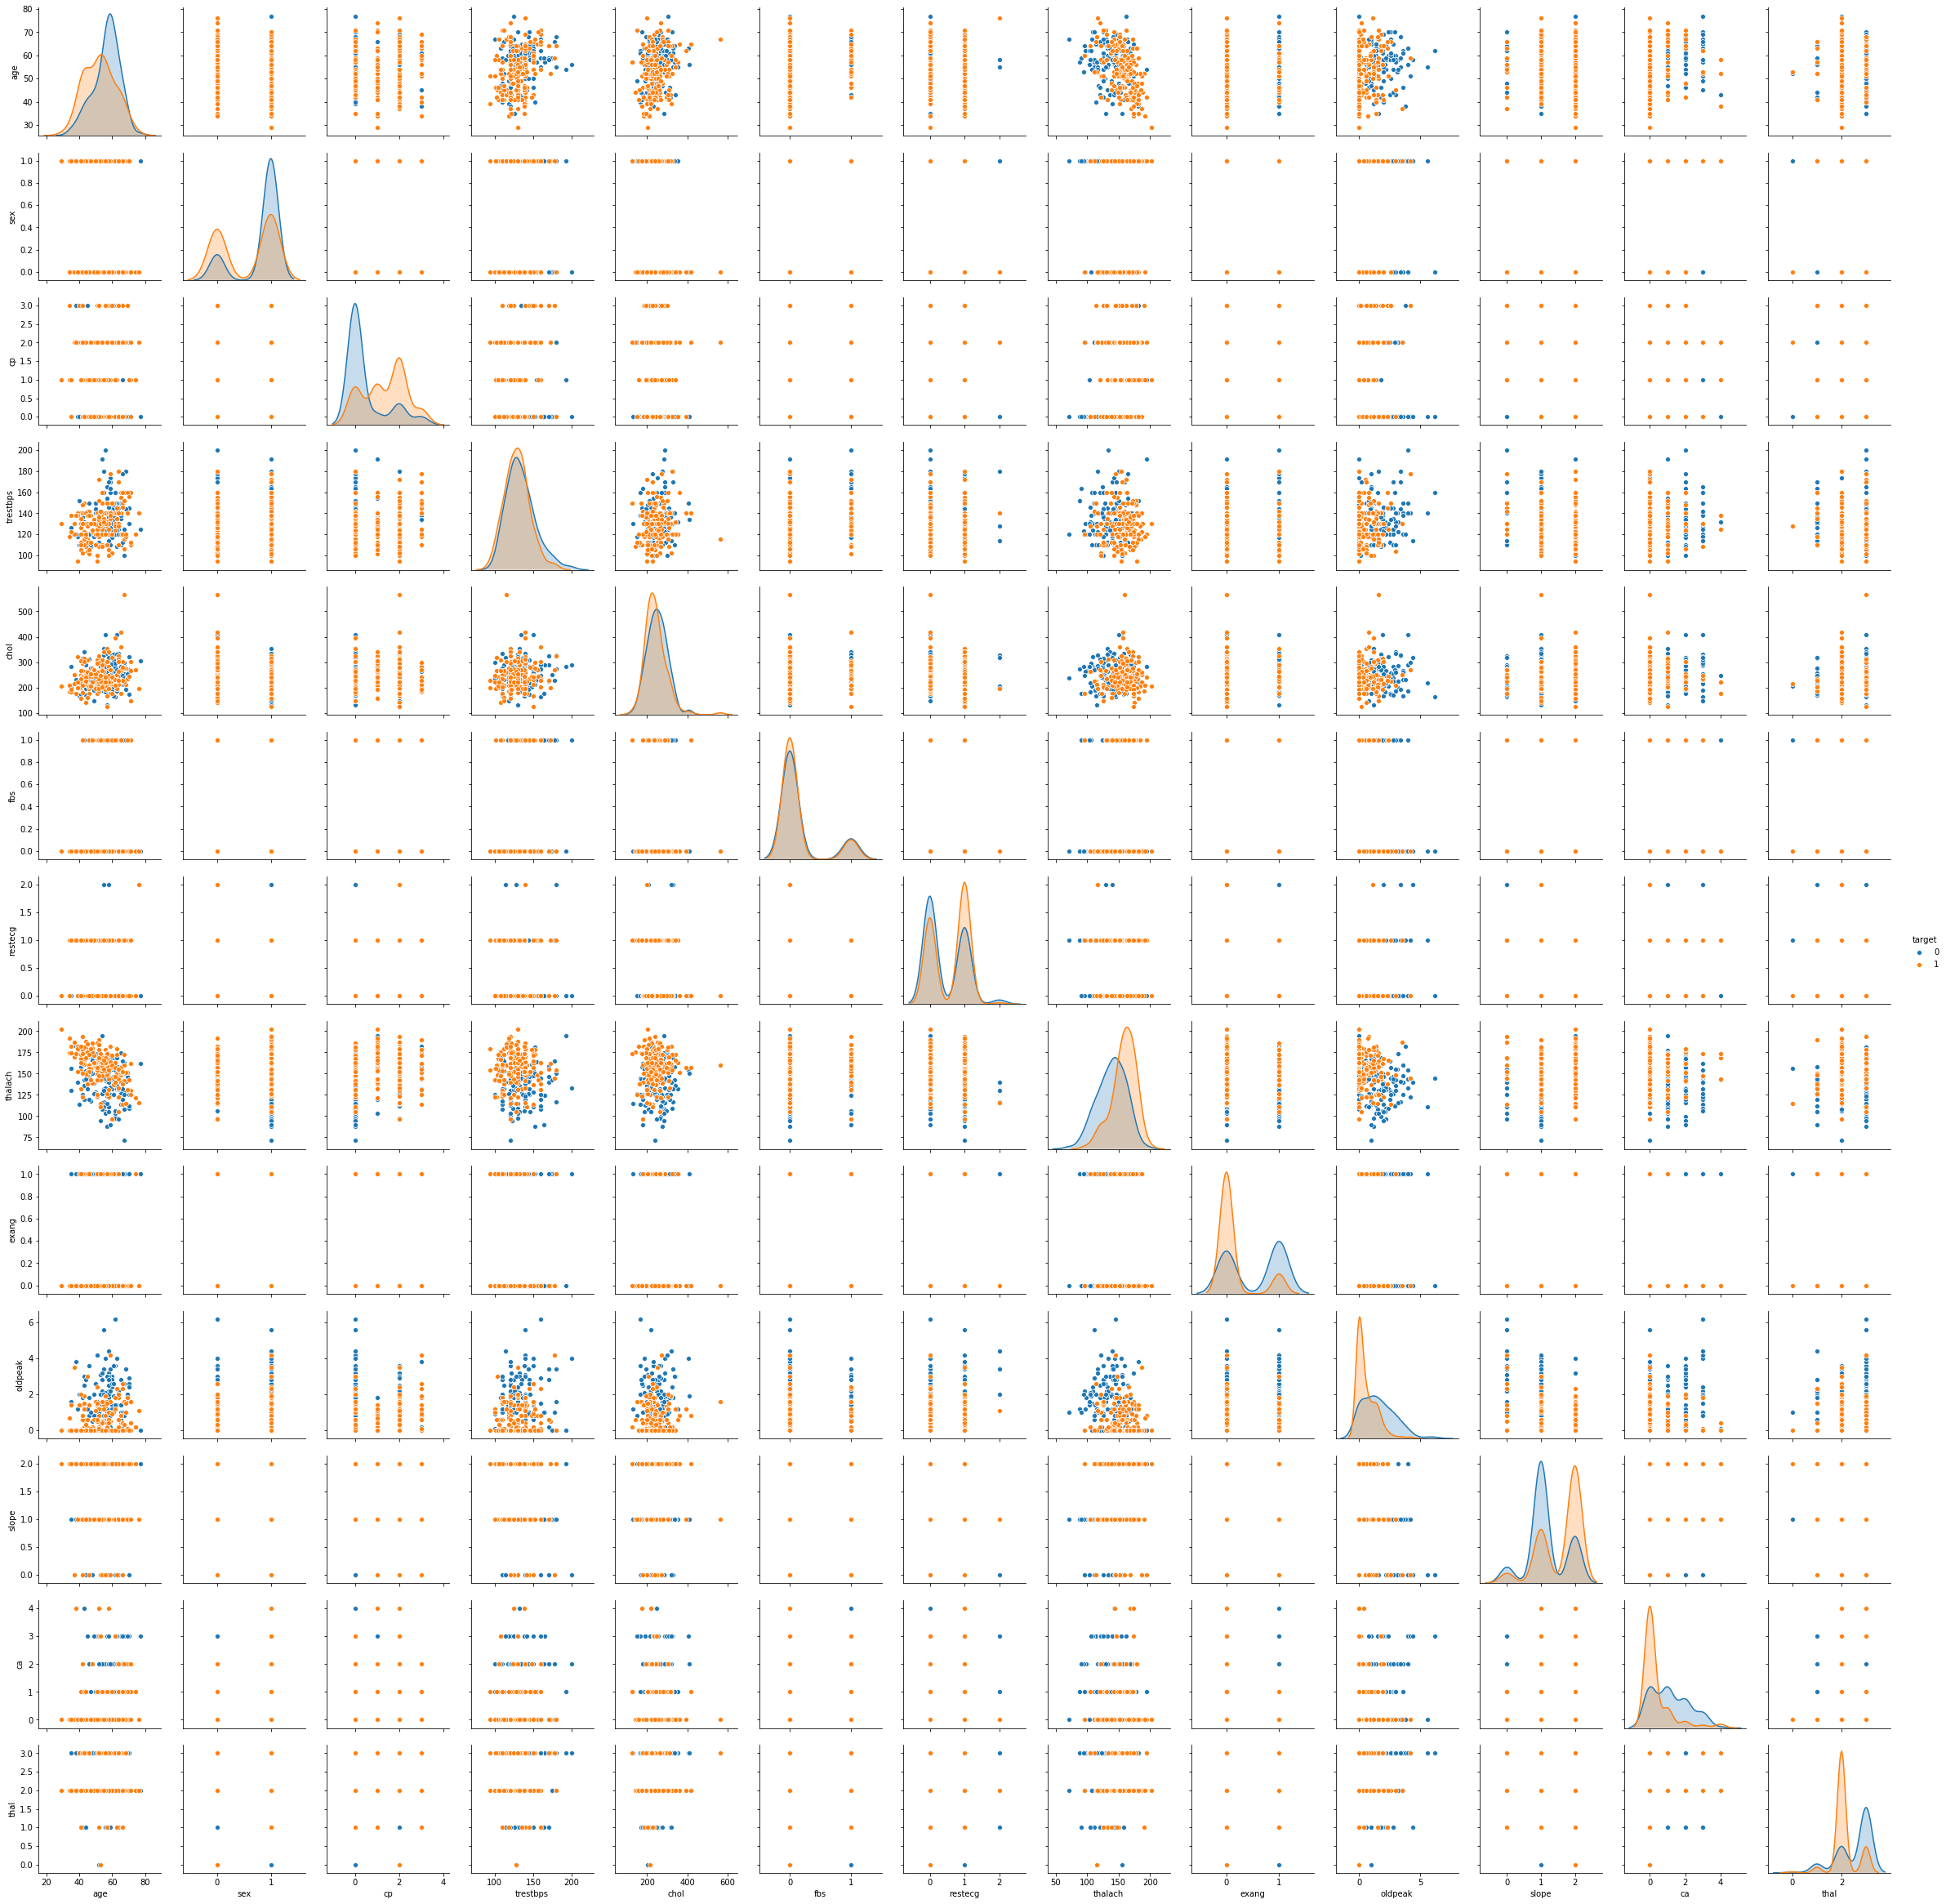

In [4]:
sns.pairplot(dataset, hue="target", vars=dataset.columns[dataset.columns != "target"])

<font color='red'>Task: What can we learn from these plots ?</font>

- The diagonal looks at the distribution of a single feature. The color indicates the target.
- The non-diagonal plots show the relationship between two features.

Our dataset consists of two types of features:
- **Categorical features** can only take one of a limited set of **discrete** values
- **Continuous features** on the other hand can take any value within a reasonable range.

The plots with categorical features are harder to interpret since many points are overlapping. Seaborn has the *catplot* function that is useful in this case. It makes a scatterplot without overlapping datapoints


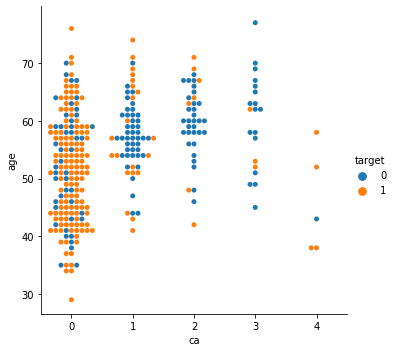

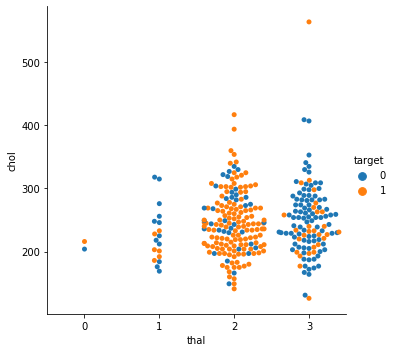

In [5]:
sns.catplot(x="ca", y="age", kind="swarm", data=dataset, hue="target")
sns.catplot(x="thal", y="chol", kind="swarm", data=dataset, hue="target")

## Data preprocessing
Before we can train our models we have to do some data preprocessing.
### 1. Replace categorical features with one-hot encodings
Categorical features are often misleading to the model since the model might assume some kind of order or hierarchy in them. To avoid this we encode them using a **one-hot encoding** where we generate **dummy columns** for each possible value of a discrete variable.

In [6]:
a = pd.get_dummies(dataset['cp'], prefix = "cp")
b = pd.get_dummies(dataset['thal'], prefix = "thal")
c = pd.get_dummies(dataset['slope'], prefix = "slope")

frames = [dataset, a, b, c]
dataset = pd.concat(frames, axis = 1)
dataset.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target,cp_0,cp_1,cp_2,cp_3,thal_0,thal_1,thal_2,thal_3,slope_0,slope_1,slope_2
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1,0,0,0,1,0,1,0,0,1,0,0
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1,0,0,1,0,0,0,1,0,1,0,0
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1,0,1,0,0,0,0,1,0,0,0,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1,0,1,0,0,0,0,1,0,0,0,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1,1,0,0,0,0,0,1,0,0,0,1


In [7]:
dataset.drop(['cp'], inplace=True, axis=1)
dataset.drop(['thal'], inplace=True, axis=1)
dataset.drop(['slope'], inplace=True, axis=1)
dataset.head()

,age,sex,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,ca,target,cp_0,cp_1,cp_2,cp_3,thal_0,thal_1,thal_2,thal_3,slope_0,slope_1,slope_2
0,63,1,145,233,1,0,150,0,2.3,0,1,0,0,0,1,0,1,0,0,1,0,0
1,37,1,130,250,0,1,187,0,3.5,0,1,0,0,1,0,0,0,1,0,1,0,0
2,41,0,130,204,0,0,172,0,1.4,0,1,0,1,0,0,0,0,1,0,0,0,1
3,56,1,120,236,0,1,178,0,0.8,0,1,0,1,0,0,0,0,1,0,0,0,1
4,57,0,120,354,0,1,163,1,0.6,0,1,1,0,0,0,0,0,1,0,0,0,1


### 2. Normalize the data
We will use feature-wise distance metrics later that are sensitive to the scale of the features. The next step is therefore to **normalize** the data. Otherwise the distance metric will put more weight on features that have a higher range of possible values. We should only normalize the columns with continuous values, not the ones with discrete or one-hot values. Another option would be to **Standardize** the data. By subtracting the mean and dividing by the standard deviation, we obtain data centered around 0 (the mean is 0) with a unit standard deviation (standard deviation of 1). The benefit of standardization is that it is less sensitive to outliers.

In [8]:
columns = ["age", "trestbps", "chol", "thalach", "oldpeak"]
dataset[columns] = (dataset[columns] - np.min(dataset[columns])) / (np.max(dataset[columns]) - np.min(dataset[columns])).values
dataset.describe()

,age,sex,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,ca,target,cp_0,cp_1,cp_2,cp_3,thal_0,thal_1,thal_2,thal_3,slope_0,slope_1,slope_2
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,0.528465,0.683168,0.354941,0.274575,0.148515,0.528053,0.600358,0.326733,0.167678,0.729373,0.544554,0.471947,0.165017,0.287129,0.075908,0.006601,0.059406,0.547855,0.386139,0.069307,0.462046,0.468647
std,0.189210,0.466011,0.165454,0.118335,0.356198,0.525860,0.174849,0.469794,0.187270,1.022606,0.498835,0.500038,0.371809,0.453171,0.265288,0.081110,0.236774,0.498528,0.487668,0.254395,0.499382,0.499842
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.385417,0.000000,0.245283,0.194064,0.000000,0.000000,0.477099,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.541667,1.000000,0.339623,0.260274,0.000000,1.000000,0.625954,0.000000,0.129032,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
75%,0.666667,1.000000,0.433962,0.339041,0.000000,1.000000,0.725191,1.000000,0.258065,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000,4.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### 3. Split data
Just like in the previous session, we split the dataset in a **training** and **test set**.

In [9]:
from sklearn.model_selection import train_test_split
y = dataset.target.values
x = dataset.drop(['target'], axis = 1)
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size = 0.2,random_state=0)
print(len(x_train))
print(len(x_test))
print(len(y_train))
print(len(y_test))

242
61
242
61


# 1. K-nearest neighbors
K-nearest neighbors (**k-nn**) is arguably one of the simplest classification models you can think of. It simply looks at the $K$ points in the training set that are the most similar to the test input, counts how many members of each class are in this set and returns that fraction as the estimate. K-nearest neighbors is an example of **memory-based learning** or **instance based learning**. These models have to store the training data in some sort of lookup table and try to **generalize** from this. The special case when $K=1$ is called the **nearest neighbor classifier**.

## Distance metrics
To determine which points in the training set are the closest to the test sample, we need to define some kind of **distance metric**. A distance metric returns a single value that is smaller if two points are similar. A distance metric $d$ has to satisfy to following properties:
- **Positivity**: $d(x, y) \geq 0$ for all $x$ and $y$
- **Identity**: $d(x,y)=0$ if and only if $x=y$
- **Symmetry**: $d(x,y) = d(y,x)$ for all $x$ and $y$
- **Triangle inequality**: $d(x,y) \leq d(x,z) + d(z, y)$ for all $x$, $y$, $z$

Some typical examples of distance metrics are the **Euclidean distance**, the **Manhattan distance** or the generalized **$L_k$** distance. Some other commonly used measures like the **cosine similarity** do not meet these criteria and are therefore not a distance metric although they are still very useful for certain problems. Cosine similarity is for example commonly used for sentiment analysis in text documents.

The $L_k$ distance metric or **norm** is defined as: $d_k(p, q) = \sqrt[k]{\sum_{i=1}^{d} |p_i - q_i|^k}$

The parameter $k$ provides a way to trade off between the largest and the total dimensional differences:
- **$k = 1$**: The distance is the sum of the absolute values of the differences along each dimension. This is often called the **Manhattan distance** or **City-block distance**.
- **$k = 2$**: The most common distance metric. It puts more weight on the dimension with the largest difference. This version is called the **Euclidean distance**
- **$k = \infty$**: Returns the largest single dimensional difference as the distance.

## The algorithm
K-nn simply looks at the $K$ points in the training set that are the closest to the test input, counts how many members of each class are in this set and returns that fraction as the estimate. The naive way to find the $K$ neighbors would be to loop over the dataset, comparing every element with the query. This has an $O(n)$ complexity. A better choice would be to store the data in a **K-D tree** which allows for $O(\log n)$ operations on average.

<font color='red'>Task: Implement a class that performs K-nn. The fit method stores the training data in a KDTree (https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KDTree.html). The predict method retrieves the $K$ most similar training data points from the data structure and returns the fraction of positive examples.    </font>

In [10]:
from sklearn.neighbors import KDTree

class MyKNeighborsClassifier:
    def __init__(self, k):
        self.k = k
    def fit(self, x, y):
        self.tree = KDTree(x) ;
        self.y = y
    def predict(self, x):
        _, ind = self.tree.query(x, k=self.k)
        return self.y[ind].mean(axis=1)

In [11]:
knn = MyKNeighborsClassifier(10)
knn.fit(x_train, y_train)
predictions = knn.predict(x_test)  > 0.5

In [12]:
predictions

array([False,  True,  True, False, False, False, False, False, False,
       False,  True,  True, False,  True,  True,  True, False,  True,
       False,  True,  True, False, False, False,  True, False, False,
       False,  True,  True,  True, False,  True,  True,  True,  True,
       False,  True, False, False,  True,  True, False, False, False,
        True,  True, False, False,  True,  True,  True,  True,  True,
        True, False,  True,  True,  True,  True,  True])

## Accuracy metrics
Once our model is trained, we need to evaluate it on the test data to determine how good it actually is. In the case of binary classification where we have a **positive** and a **negative** class, we distinguish between:
- **True positives** (TP): We predicted the positive class and it was indeed a positive example.
- **True negatives** (TN): We predicted the negative class and it was indeed a negative example.
- **False positives** (FP): We predicted the positive class but it was a negative example. 
- **False negatives** (FN): We predicted the negative class but it was a positive example.


Based on these measurements we can then define scores such as:
- **Accuracy** $= \frac{TP + TN}{TP + TN + FN + FP}$. The fraction of correctly classified examples.
- **Precision** $= \frac{TP}{TP+FP}$. What part of the examples that we predicted to be positive, were actually positive ?
- **Recall** $=\frac{TP}{TP + FN}$. What part of the positive examples have we predicted to be positive ? Also called **sensitivity** or **True positive rate**.
- **F1-score** $= 2*\frac{precision*recall}{precision+recall}$: The harmonic mean of precision and recall.
- **False positive rate** $=\frac{FP}{FP+TN}$: What part of the negative examples have we predicted to be positive ?
- **False negative rate** $=\frac{FN}{FN+TP}$ : What part of the positive examples have we predicted to be negative ?

Accuracy is the most natural metric but you have to be careful if the classes are not balanced since the classifier could then always return the label of the most common class without having learned anything useful. It is not always clear which metric is the most important for your problem. In the case of a search engine for example we can define True Positives as relevant search results that were returned to the user and False Negatives as relevant results that were not shown to the user. We could then argue that Recall is not that important as long as some of the positive results have been returned. Similarly, we could argue that Precision is not that important as long as some of the returned results were positive.

<font color='red'>Task: Calculate the accuracy, Precision, Recall and F-score for our classifier on the test set</font>

In [13]:
accuracy = (predictions == y_test).mean()
print(accuracy)

TP = (predictions[y_test == 1] == 1).sum()
print(TP)

TN = (predictions[y_test == 0] == 0).sum()
print(TN)

FP = (predictions[y_test == 1] == 0).sum()
print(FP)

FN = (predictions[y_test == 0] == 1).sum()
print(FN)

accuracy = (TP+TN)/(TP+TN+FN+FP)
print(accuracy)

precision = TP / (TP + FP)
print(precision)

recall = TP / (TP + FN)
print(recall)

F1 = 2 *  (precision*recall)/(precision+recall)
print(F1)

0.8688524590163934
30
23
4
4
0.8688524590163934
0.8823529411764706
0.8823529411764706
0.8823529411764706


<font color='red'>Task: Plot the accuracy of the model for different choices of $K$</font>

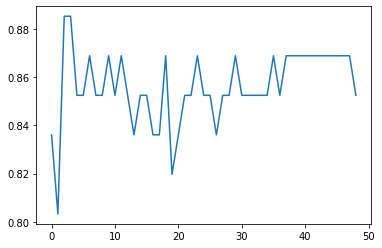

In [14]:
accuracies = []
for k in range(1, 50):
    knn = MyKNeighborsClassifier(k)
    knn.fit(x_train, y_train)
    predictions = knn.predict(x_test)  > 0.5
    accuracies.append((predictions == y_test).mean())
plt.plot(accuracies)

As you see, $K$ has a major impact on the performace of the model. $K$ is called a **hyperparameter**. It is not a trainable parameter of the model but it has to be configured manually. The optimal choice depends entirely on the data. It might be tempting to try a lot of different $K$ values and to look at the test accuracy to pick the one with the highest accuracy. This is dangerous because this specific $K$ could just happen to be the best value on this specific split of train/test data and it might not be the best $K$ for new data. It is therefore not enough to split our dataset in two, we should actually split it in three parts:
- A **train set**: to train our model
- A **validation set**: To test our model during development and to optimize hyperparameters. This is also called a **development set**.
- A **test set**: To test the model when we are done. This test data should be set aside and should not be touched while designing the model.

In our k-nn algorithm, we count how many of the neighbors belong to the positive and negative class and use the fraction of these two counts to return a positive or negative prediction for the input sample. If all neighbors belong to the same class, it is easy to return a prediction but what do we do if we have conflicting signals ? The easiest solution is to just count and to return the class with the highest number of corresponding neighbors. This is the same as calculating the fraction of neighbors that belongs to the positive class compare to the negative class and to return a positive label if this fraction is large than 0.5. We can however put this **threshold** at any arbitrary value. There is no guarantee that 0.5 is the optimal value, our classifier might obtain higher scores with a different threshold. This means that the threshold is also a **hyperparameter** that we can optimize. Depending on your problem, you might want a high precision (very low number of false positives). In this case it would be a good idea to increase the threshold since the model now needs to be more confident before it returns a positive prediction. To compare all possible thresholds we can use the **Receiver-Operator Characteristic (ROC) curve)**. Each point on this curve represents a particular threshold. Each threshold results in a certain **true positive rate (TPR)** and **false positive rate (FPR)** that are plotted on the x-axis and y-axis respectively. The diagonal represents points with an equal TPR and FPR which indicates random predictions. A good classifier has a ROC curve that lies above the diagonal, as close to the upper left corner as possible. The best possible ROC curve goes immediately to the upper left corner meaning it classifies all positive examples immediately as positive. It then steps to the right with each negative example it encounters until it reaches the upper right corner.

We can summarize the ROC curve into a single value by calculating the **Area under the curve (AUC)**. The best possible classifier has an area of 1 while a random classifier has an area of 0.5. The AUC score allows us to compare two classifiers without having to set the threshold manually.

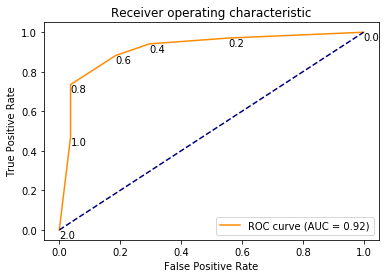

In [15]:
from sklearn.metrics import roc_curve, auc

knn = MyKNeighborsClassifier(5)
knn.fit(x_train, y_train)
predictions = knn.predict(x_test)

fpr, tpr, thresholds = roc_curve(y_test, predictions)
roc_auc = auc(fpr, tpr)
        
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')

for x, y, txt in zip(fpr, tpr, thresholds):
    plt.annotate(np.round(txt,2), (x, y-0.04))
    
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")

## Remarks
- Just like our linear regression model, k-nn models can be sensitive to **outliers**. Depending on your data, the model could benefit form **data cleaning** and **outlier removal** prior to training.
- There are many variants of the k-nn algorithm. A common variant is **Weighted k-nn** where the class is determined by weighted voting of the neighbors. The weights are determined by the distance to the test input.
- Since the complexity (both of storage and compute) scale with the number of training points, it might be a good idea to try to remove as much redundant training samples as possible. The goal is then to replace the training set by a **consistent subset**, a smaller set of training data that results in the same performance. There are many **heuristics** to determine this set.
- K-nn is a simple technique but is often a strong baseline. It has the added benefits that it is easily **interpretable** while still being able to model complex **non-linear decision boundaries**.
- We now used a k-nn model for classification but you can design a variant for regression. The value assigned to a query point is then computed based on the (weighted) mean of the values of its nearest neighbors.
- In this example we performed **binary classification** but in the more general case of **multiclass classification** it is always interesting to calculate a **confusion matrix** that shows how many examples of each class are classified as each class.

# 2. Logistic regression
Contrary to what the name suggests, **Logistic Regression** is not a regression model, it is a classification model. It is a modification of **linear regression** for **classification** problems. The trivial way to modify a regression model for classification is to encode the target as a number (0: no heart disease, 1: heart disease) and to try to predict this actual value using regression. We could then interpret the predicted value (e.g. 0.8) as the probability of heart disease. Our linear regression model however is not limited to return numbers between 0 and 1, it can return any real number as a prediction. **Logistic regression** simply forces the output to be between 0 and 1 using a **logistic** or **sigmoid** function:

$f(x) = \frac{1}{1 + e^{-x}}$

Sigmoid means S-shaped. It is a **squashing** function since it maps the whole real domain to [0, 1]. Logistic regression follows the same structure as linear regression but simply applies the Sigmoid function to the predicted value to scale it back to [0, 1]. We can then threshold this value to predict the discrete class.

<img src="images/sigmoid.png" width="400" />

Behind the scenes, logistic regression tries to find a **hyperplane** that separates the points of the different classes the best as possible. Depending on the side that a datapoint lies at, it is classified as a positive or a negative example. The distance of the point to the **decision boundary** is the output of the model and is rescaled to [0, 1] using the sigmoid function.

<font color='red'>Task: Initialize a weight vector for the model. Just like in the linear regression example from the previous assignment, this has the same number of elements as the number of input features plus one extra weight for the bias. All values can be initialized to zero.</font>

In [16]:
weights = np.zeros(x_train.shape[1]+1)
print(weights.shape)

(22,)


<font color='red'>Task: write a function predict that calculates the output of the model for a given set of weights and input features. Just like in the linear regression example from previous assignment, this is calculated by taking the dot product of the input with the weights. In the case of logistic regression, the output is then passed through a sigmoid to map the output to [0,1].</font>

In [17]:
def predict(weights, inputs):
    y = np.dot(inputs, weights)
    y = 1.0 / (1+np.exp(-y))
    return y

X = np.hstack([np.ones((len(x_train), 1)), x_train])
predictions = predict(weights, X)

## Training
In the previous session we used a closed form solution to obtain the optimal weights for our model. Here, we will use the more general **gradient descent** method to find the weights iteratively. We can not use the closed form solution in the case of logistic regression since the sigmoid function adds a **non-linearity**.

Gradient descent (sometimes also called **Steepest descent** is an iterative method that makes small changes to the weights during training until a good combination is found. To train our model, we use random values as our initial weights and calculate a **loss function** that indicates how good these weights are. We then calculate the **partial derivatives** of the loss function with respect to the weights of our model. These partial derivatives tell use whether we should increase or decrease the parameter value to reduce the loss. We then take small steps in these directions to obtain the new parameter values. This is repeated iteratively until good weights are found. The name "gradient descent" refers to the fact that it uses the gradient to navigate the **loss landscape**. Gradient descent will find the optimal point (The **global minimum**) as long as the loss landscape is **convex**. In case of a **non-convex** surface there will be one or more **local minima** with a loss value that is higher that the **global minimum**. Gradient descent only guarantees us to find a local minimum.

<img src="images/convex_cost_function.jpg" width="800" />

Gradient descent is commonly used in the case of **non-convex optimization** but in the case of Logistic regression we can force our problem to be convex by carefully choosing the loss function. We will use the **cross-entropy** or **negative log-likelihood loss** function as our loss function since this will result in a convex loss landscape where **mean squared error** would result in a non-convex loss. The cross entropy loss function is defined as 

$  cost = \begin{cases} 
      -log(h(x)) &  \text{if y=1} \\
      -log(1 - h(x)) & \text{if y=0}
   \end{cases}
$

Where $h(x)$ is the output of our model and y indicates whether the sample is positive or negative. The loss function can then be visualized as:

<img src="images/nll.png" width="400"  />

If the actual class is 1 and the model predicts 0, we should highly penalize it and vice-versa. As you can see from the below picture, for the plot $-log(h(x))$ as $h(x)$ approaches 1, the cost is 0 and as $h(x)$ nears 0, the cost is infinity (that is we penalize the model heavily). Similarly for the plot $-log(1-h(x))$ when the actual value is 0 and the model predicts 0, the cost is 0 and the cost becomes infinity as $h(x)$ approaches 1.
The cost for all $n$ training examples in our dataset is then:

$J(\theta) = - \frac{1}{n}\sum_{i=1}^{n} [y_i log(h(x_i)) + (1-y_i) log(1 - h(x_i))]$

<font color='red'>Task: write a function "loss" that calculates the loss of the model for a given set of predictions and targets</font>

In [18]:
def loss(predictions, targets):
    t =  targets * np.log(predictions) + (1-targets)*np.log(1-predictions)
    return -np.mean(t)
l = loss(predictions, y_train)
print(l)

0.6931471805599453


The gradient of the loss function with respect to a parameter $\theta_j$ is given by:

$ \frac{\partial J(\theta)}{\partial \theta_j} = \frac{1}{n} \sum_{i=1}^n (h(x_i) - y_i)x_i^j$

<font color='red'>Task: write a function "gradient" that calculates the gradient of the loss of the model with respect to the parameters</font>

In [19]:
def gradient(inputs, predictions, targets):
    return np.dot((predictions-targets), inputs)/len(inputs)
p = gradient(X, predictions, y_train)
print(p)

[-0.04132231 -0.002927    0.04752066 -0.00345002 -0.00766067  0.00413223
 -0.04132231 -0.06062709  0.08884298  0.03255798  0.19008264  0.1053719
 -0.04545455 -0.08471074 -0.01652893  0.          0.01652893 -0.15702479
  0.09917355  0.00206612  0.06404959 -0.10743802]


Once we have the gradient, we can update our weights following the gradient descent rule:
$ \theta^{k+1} = \theta^k - \lambda g^k $ where $\lambda$ is the **stepsize** or **learning rate**, a hyperparameter set by the model developer.

<font color='red'>Task: write a function "train" that goes over the training set multiple times and that updates the weights using the gradient descent method. Keep track of the loss during the different iterations.</font>

[ 0.26097278  0.04953092 -0.2535752   0.02221225  0.04266236 -0.00982135
  0.19036097  0.34016215 -0.4246509  -0.16221218 -0.65708255 -0.48537843
  0.21742543  0.41893873  0.10998705 -0.00351966 -0.06533122  0.75270133
 -0.42287767 -0.00817262 -0.20278237  0.47192776]


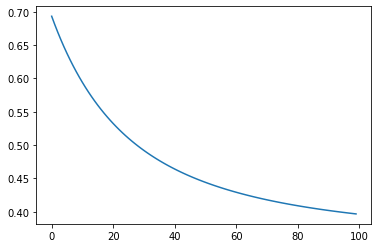

In [20]:
def train(inputs, targets, weights, lr=0.1):
    losses = []
    for _ in range(100):
        predictions = predict(weights, inputs)
        l = loss(predictions, targets)
        losses.append(l)
        g = gradient(inputs, predictions, targets)       
        weights = weights - lr * g
    return losses, weights

losses, trained_weights = train(X, y_train, weights)
plt.plot(losses)
print(trained_weights)

<font color='red'>Task: Calculate the accuracy, Precision, Recall and F-score for our classifier on the test set</font>

In [21]:
predictions = predict(trained_weights, np.hstack([np.ones((len(x_test), 1)), x_test]))
predictions = predictions > 0.5

accuracy = (predictions == y_test).mean()
print(accuracy)

TP = (predictions[y_test == 1] == 1).sum()
print(TP)

TN = (predictions[y_test == 0] == 0).sum()
print(TN)

FP = (predictions[y_test == 0] == 1).sum()
print(FP)

FN = (predictions[y_test == 1] == 0).sum()
print(FN)

accuracy = (TP+TN)/(TP+TN+FN+FP)
print(accuracy)

precision = TP / (TP + FP)
print(precision)

recall = TP / (TP + FN)
print(recall)

F1 = 2 *  (precision*recall)/(precision+recall)
print(F1)

0.8688524590163934
29
24
3
5
0.8688524590163934
0.90625
0.8529411764705882
0.8787878787878787


## Logistic regression using scikit-learn
We now implemented a simple logistic regression algorithm from scratch. When analyzing real data you should use existing implementations such as those from sklearn.

In [22]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(random_state=0)
model.fit(x_train, y_train)

print(model.predict(x_test))
print(model.predict_proba(x_test))

[0 0 1 0 0 0 0 0 0 0 1 1 0 1 1 1 0 1 0 1 1 0 0 0 1 1 0 0 1 1 1 0 1 1 1 1 0
 1 0 0 0 1 0 0 1 1 1 0 0 1 1 1 1 1 1 0 1 1 1 1 1]
[[0.87858291 0.12141709]
 [0.51039396 0.48960604]
 [0.49664951 0.50335049]
 [0.96485426 0.03514574]
 [0.9121738  0.0878262 ]
 [0.73994267 0.26005733]
 [0.89538296 0.10461704]
 [0.91049976 0.08950024]
 [0.9697674  0.0302326 ]
 [0.98865204 0.01134796]
 [0.36291227 0.63708773]
 [0.07742831 0.92257169]
 [0.93959121 0.06040879]
 [0.0898397  0.9101603 ]
 [0.04271181 0.95728819]
 [0.21598393 0.78401607]
 [0.94504639 0.05495361]
 [0.2365348  0.7634652 ]
 [0.98423733 0.01576267]
 [0.22193508 0.77806492]
 [0.1863811  0.8136189 ]
 [0.73615828 0.26384172]
 [0.82538208 0.17461792]
 [0.81062507 0.18937493]
 [0.07567688 0.92432312]
 [0.42424249 0.57575751]
 [0.86901849 0.13098151]
 [0.59770165 0.40229835]
 [0.03482632 0.96517368]
 [0.20588926 0.79411074]
 [0.1979707  0.8020293 ]
 [0.99002998 0.00997002]
 [0.02820478 0.97179522]
 [0.24325125 0.75674875]
 [0.06487943 0.93512057]


In [23]:
print(model.coef_)
print(model.intercept_)

[[-0.30737606 -1.14686373 -0.59462864 -0.53933125 -0.15953442  0.1602217
   0.88270492 -0.74568815 -1.10243959 -0.88093797 -1.01411164  0.01962126
   0.6099628   0.38451032 -0.13975732  0.04230733  0.74685824 -0.6494255
   0.02973936 -0.40754198  0.37778537]]
[2.09324974]


In [24]:
print(model.score(x_test, y_test))

0.8360655737704918


## Remarks
- In this case we applied logistic regression to binary classification. It is relatively straight-forward to extend it to **multi-class classification**.
- Gradient descent is a very popular algorithm that is commonly used to train large models such as neural networks even though their loss function is not convex. There are techniques such as **momentum** that can help in this case.
- In this example we used the full training set to calculate the gradient at each step. This is known as **batch gradient descent**. This is only feasible here because our dataset is very small. We can also estimate the gradient with just a single input data point. In this case (**Stochastic gradient descent**), we take a step after each example. This is faster but since the gradient estimates are noisy, the cost will fluctuate during training and we might not reach the lowest minimum. Noise is however not necessarily bad, especially in the case of non-convex optimization with gradient descent (e.g. neural networks), this noise might help us to escape a local minimum. The most common version of gradient descent tries to take the best of both world. With **mini batch gradient descent** we estimate the gradient using a small subset of the training data for each step: a **minibatch** of data. Typical minibatch sizes are 32, 64, 128.